# Retriever Evaluation with MLflow

In MLflow 2.8.0, we introduced a new model type "retriever" to the `mlflow.evaluate()` API. It helps you to evaluate the retriever in a RAG application. It contains two built-in metrics `precision_at_k` and `recall_at_k`. In MLflow 2.9.0, `ndcg_at_k` is available.

This notebook illustrates how to use `mlflow.evaluate()` to evaluate the retriever in a RAG application. It has the following steps:

* Step 1: Install and Load Packages
* Step 2: Evaluation Dataset Preparation
* Step 3: Calling `mlflow.evaluate()`
* Step 4: Result Analysis and Visualization

## Step 1: Install and Load Packages

In [2]:
# !pip install mlflow==2.9.0 langchain==0.0.339 openai faiss-cpu gensim nltk pyLDAvis tiktoken
# !pip install  faiss-cpu gensim nltk pyLDAvis tiktoken


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 48.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 69.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 65.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 71.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 76.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 95.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━

In [3]:
import ast
import os
import pprint
from typing import List

import pandas as pd
from langchain.docstore.document import Document
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.text_splitter import CharacterTextSplitter
from langchain.vectorstores import FAISS

import mlflow

os.environ["OPENAI_API_KEY"] = "key-here"

CHUNK_SIZE = 100 # WARNING! MAKE SURE ITS SAME. CHUNK_SIZE = 100 # Warning : Change in other notebook as well. # IRRELEVANT SINCE THE ALREAYD BUILT DATABAES IS USED

# Assume running from https://github.com/mlflow/mlflow/blob/master/examples/llms/rag
OUTPUT_DF_PATH = "/projects/bcjp/marshad/agllm/agllm-data/evaluation/question_answer_source_agllm.csv"
SCRAPPED_DOCS_PATH = "None"
EVALUATION_DATASET_PATH = "/projects/bcjp/marshad/agllm/agllm-data/evaluation/static_evaluation_dataset.csv" # This is where/how the dataset will be saved when it is prepared for evaluation
DB_PERSIST_DIR = "faiss_index"

## Step 2: Evaluation Dataset Preparation
The evaluation dataset should contain three columns: questions, ground truth doc IDs, retrieved relevant doc IDs. A "doc ID" is a unique string identifier of the documents in you RAG application. For example, it could be the URL of a documentation web page, or the file path of a PDF document.

If you have a list of questions that you would like to evaluate, please see 1.1 Manual Preparation. If you do not have a question list yet, please see 1.2 Generate the Evaluation Dataset.


### Manual Preparation

When evaluating a retriever, it's recommended to save the retrieved document IDs into a static dataset represented by a Pandas Dataframe or an MLflow Pandas Dataset containing the input queries, retrieved relevant document IDs, and the ground-truth document IDs for the evaluation.

#### Concepts

A "document ID" is a string that identifies a document.

A list of "retrieved relevant document IDs" are the output of the retriever for a specific input query and a `k` value.

A list of "ground-truth document IDs" are the labeled relevant documents for a specific input query.

#### Expected Data Format

For each row, the retrieved relevant document IDs and the ground-truth relevant document IDs should be provided as a tuple of document ID strings.

The column name of the retrieved relevant document IDs should be specified by the `predictions` parameter, and the column name of the ground-truth relevant document IDs should be specified by the `targets` parameter.

Here is a simple example dataset that illustrates the expected data format. The doc IDs are the paths of the documentation pages.

In [42]:
# # THIS IS NO BEING USED INSTEAD : QUESTION_ANSWER_SOURCE (GENERATED FROM LAST NOTEBOOK IS BEING USED)
# data = pd.DataFrame(
#     {
#         "questions": [
#             "What is MLflow?",
#             "What is Databricks?",
#             "How to serve a model on Databricks?",
#             "How to enable MLflow Autologging for my workspace by default?",
#         ],
#         "retrieved_context": [
#             [
#                 "mlflow/index.html",
#                 "mlflow/quick-start.html",
#             ],
#             [
#                 "introduction/index.html",
#                 "getting-started/overview.html",
#             ],
#             [
#                 "machine-learning/model-serving/index.html",
#                 "machine-learning/model-serving/model-serving-intro.html",
#             ],
#             [],
#         ],
#         "ground_truth_context": [
#             ["mlflow/index.html"],
#             ["introduction/index.html"],
#             [
#                 "machine-learning/model-serving/index.html",
#                 "machine-learning/model-serving/llm-optimized-model-serving.html",
#             ],
#             ["mlflow/databricks-autologging.html"],
#         ],
#     }
# )

### Generate the Evaluation Dataset
There are two steps to generate the evaluation dataset: generate questions with ground truth doc IDs and retrieve relevant doc IDs. 


#### Generate Questions with Ground Truth Doc IDs
If you don't have a list of questions to evaluate, you can generate them using LLMs. The [Question Generation Notebook](https://mlflow.org/docs/latest/llms/rag/notebooks/question-generation-retrieval-evaluation.html) provides an example way to do it. Here is the result of running that notebook.

In [4]:
generated_df = pd.read_csv(OUTPUT_DF_PATH)

In [5]:
generated_df.head(3)

question  \
0  When does peak adult flight of stalk borer occur?   
1  What are the distinguishing features of stalk ...   

                                              answer  \
0  Peak adult flight of stalk borer occurs during...   
1  Stalk borer larvae have three pairs of true le...   

                                               chunk  chunk_id  \
0  11/10/23, 9:03 AM\nStart Scouting for Stalk Bo...         0   
1  Description. Stalk borer larvae have three pai...         0   

                                              source  
0  agllm-data/Start Scouting for Stalk Borer _ In...  
1  agllm-data/Start Scouting for Stalk Borer _ In...

In [6]:
# Prepare dataframe `data` with the required format
data = pd.DataFrame({})
data["question"] = generated_df["question"].copy(deep=True)
data["source"] = generated_df["source"].apply(lambda x: [x])
data.head(3)

question  \
0  When does peak adult flight of stalk borer occur?   
1  What are the distinguishing features of stalk ...   

                                              source  
0  [agllm-data/Start Scouting for Stalk Borer _ I...  
1  [agllm-data/Start Scouting for Stalk Borer _ I...

#### Retrieve Relevant Doc IDs

Once we have a list of questions with ground truth doc IDs from 1.1, we can collect the retrieved relevant doc IDs. In this tutorial, we use a LangChain retriever. You can plug in your own retriever as needed.

First, we build a FAISS retriever from the docs saved at https://github.com/mlflow/mlflow/blob/master/examples/llms/question_generation/mlflow_docs_scraped.csv. See the [Question Generation Notebook](https://mlflow.org/docs/latest/llms/rag/notebooks/question-generation-retrieval-evaluation.html) for how to create this csv file.

In [7]:
embedding = OpenAIEmbeddings()

/u/marshad/.conda/envs/agllm-env1/lib/python3.9/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.embeddings.openai.OpenAIEmbeddings` was deprecated in langchain-community 0.0.9 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(


In [47]:
# scrapped_df = pd.read_csv(SCRAPPED_DOCS_PATH)
# list_of_documents = [
#     Document(page_content=row["text"], metadata={"source": row["source"]})
#     for i, row in scrapped_df.iterrows()
# ]
# text_splitter = CharacterTextSplitter(chunk_size=CHUNK_SIZE, chunk_overlap=0)
# docs = text_splitter.split_documents(list_of_documents)
# db = FAISS.from_documents(docs, embeddings)

# # Save the db to local disk
# db.save_local(DB_PERSIST_DIR)

In [10]:
# Load the db from local disk : Already stored database that is being used in agllm should come here
# db = FAISS.load_local(DB_PERSIST_DIR, embeddings)
from langchain.vectorstores import Chroma

persist_directory = 'db3'
vectordb = Chroma(persist_directory=persist_directory, 
                  embedding_function=embedding)

retriever = vectordb.as_retriever()

In [11]:
# Test the retriever with a query
retrieved_docs = retriever.get_relevant_documents(
    "What is the purpose of the MLflow Model Registry?"
)
(retrieved_docs)

[Document(page_content='Control. To prevent stand loss, scout and determine the percent of infested plants.\nThe use of an economic threshold (Table 1), first developed by ISU entomologist\nLarry Pedigo, will help determine justifiable insecticide treatments based on market\nvalue and plant stage. Young plants have a lower threshold because they are more\neasily killed by stalk borer larvae.\nTable 1. Economic thresholds for stalk borer in corn, based on plant\nstage, expected yield and market value.', metadata={'author': '', 'creationDate': "D:20231110150309+00'00'", 'creator': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/118.0.0.0 Safari/537.36', 'file_path': 'agllm-data/Start Scouting for Stalk Borer _ Integrated Crop Management.pdf', 'format': 'PDF 1.4', 'keywords': '', 'matched_specie_0': 'Hypagyrtis unipunctata', 'matched_specie_1': 'Papaipema nebris', 'modDate': "D:20231110150309+00'00'", 'page': 2, 'producer': 'Skia/PDF m118', 'source

After building a retriever, we define a function that takes a question string as input and returns a list of relevant doc ID strings.

In [16]:
# Define a function to return a list of retrieved doc ids
def retrieve_doc_ids(question: str) -> List[str]:
    docs = retriever.get_relevant_documents(question)
    return [doc.metadata["source"] for doc in docs]

data["retrieved_doc_ids"] = data["question"].apply(retrieve_doc_ids)
data.head(3)

question  \
0  When does peak adult flight of stalk borer occur?   
1  What are the distinguishing features of stalk ...   

                                              source  \
0  [agllm-data/Start Scouting for Stalk Borer _ I...   
1  [agllm-data/Start Scouting for Stalk Borer _ I...   

                                   retrieved_doc_ids  
0  [agllm-data/Start Scouting for Stalk Borer _ I...  
1  [agllm-data/Start Scouting for Stalk Borer _ I...

We can store the retrieved doc IDs in the dataframe as a column "retrieved_doc_ids".

In [1]:
data["question"][0]

NameError: name 'data' is not defined

In [19]:
data.iloc[0]["retrieved_doc_ids"]

['agllm-data/Start Scouting for Stalk Borer _ Integrated Crop Management.pdf',
 'agllm-data/Start Scouting for Stalk Borer _ Integrated Crop Management.pdf',
 'agllm-data/Start Scouting for Stalk Borer _ Integrated Crop Management.pdf',
 'agllm-data/Start Scouting for Stalk Borer _ Integrated Crop Management.pdf']

In [20]:
# Persist the static evaluation dataset to disk
data.to_csv(EVALUATION_DATASET_PATH, index=False)

In [21]:
# Load the static evaluation dataset from disk and deserialize the source and retrieved doc ids
data = pd.read_csv(EVALUATION_DATASET_PATH)
data["source"] = data["source"].apply(ast.literal_eval)
data["retrieved_doc_ids"] = data["retrieved_doc_ids"].apply(ast.literal_eval)
data.head(3)

question  \
0  When does peak adult flight of stalk borer occur?   
1  What are the distinguishing features of stalk ...   

                                              source  \
0  [agllm-data/Start Scouting for Stalk Borer _ I...   
1  [agllm-data/Start Scouting for Stalk Borer _ I...   

                                   retrieved_doc_ids  
0  [agllm-data/Start Scouting for Stalk Borer _ I...  
1  [agllm-data/Start Scouting for Stalk Borer _ I...

## Step 3: Calling `mlflow.evaluate()`

### Metrics Definition

There are three built-in metrics provided for the retriever model type. Click the metric name below to see the metrics definitions.

1.  [mlflow.metrics.precision_at_k(k)](https://mlflow.org/docs/latest/python_api/mlflow.metrics.html#mlflow.metrics.precision_at_k)
1.  [mlflow.metrics.recall_at_k(k)](https://mlflow.org/docs/latest/python_api/mlflow.metrics.html#mlflow.metrics.recall_at_k)
1.  [mlflow.metrics.ndcg_at_k(k)](https://mlflow.org/docs/latest/python_api/mlflow.metrics.html#mlflow.metrics.ndcg_at_k) 

All metrics compute a score between 0 and 1 for each row representing the corresponding metric of the retriever model at the given `k` value.

The `k` parameter should be a positive integer representing the number of retrieved documents
to evaluate for each row. `k` defaults to 3.

When the model type is `"retriever"`, these metrics will be calculated automatically with the
default `k` value of 3.


### Basic usage

There are two supported ways to specify the retriever's output:

* Case 1: Save the retriever's output to a static evaluation dataset
* Case 2: Wrap the retriever in a function

In [22]:
print(data.iloc[0][1])
print(data.iloc[0][2])


['agllm-data/Start Scouting for Stalk Borer _ Integrated Crop Management.pdf']
['agllm-data/Start Scouting for Stalk Borer _ Integrated Crop Management.pdf', 'agllm-data/Start Scouting for Stalk Borer _ Integrated Crop Management.pdf', 'agllm-data/Start Scouting for Stalk Borer _ Integrated Crop Management.pdf', 'agllm-data/Start Scouting for Stalk Borer _ Integrated Crop Management.pdf']


/tmp/ipykernel_1842537/457881667.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(data.iloc[0][1])
/tmp/ipykernel_1842537/457881667.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(data.iloc[0][2])


In [23]:
# Case 1: Evaluating a static evaluation dataset
with mlflow.start_run() as run:
    evaluate_results = mlflow.evaluate(
        data=data,
        model_type="retriever",
        targets="source",
        predictions="retrieved_doc_ids",
        evaluators="default",
    )

/u/marshad/.conda/envs/agllm-env1/lib/python3.9/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  string_columns = trimmed_df.columns[(df.applymap(type) == str).all(0)]
/u/marshad/.conda/envs/agllm-env1/lib/python3.9/site-packages/mlflow/models/evaluation/base.py:414: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(_hash_array_like_element_as_bytes)
2024/04/19 15:45:38 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2024/04/19 15:45:39 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2024/04/19 15:45:39 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...
2024/04/19 15:45:39 INFO m

In [24]:
question_source_df = data[["question", "source"]]
question_source_df.head(3)

question  \
0  When does peak adult flight of stalk borer occur?   
1  What are the distinguishing features of stalk ...   

                                              source  
0  [agllm-data/Start Scouting for Stalk Borer _ I...  
1  [agllm-data/Start Scouting for Stalk Borer _ I...

In [71]:
# # Case 2: Evaluating a function
# def retriever_model_function(question_df: pd.DataFrame) -> pd.Series:
#     return question_df["question"].apply(retrieve_doc_ids)


# with mlflow.start_run() as run:
#     evaluate_results = mlflow.evaluate(
#         model=retriever_model_function,
#         data=question_source_df,
#         model_type="retriever",
#         targets="source",
#         evaluators="default",
#     )

In [25]:
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(evaluate_results.metrics)

{   'ndcg_at_3/mean': 1.0,
    'ndcg_at_3/p90': 1.0,
    'ndcg_at_3/variance': 0.0,
    'precision_at_3/mean': 1.0,
    'precision_at_3/p90': 1.0,
    'precision_at_3/variance': 0.0,
    'recall_at_3/mean': 1.0,
    'recall_at_3/p90': 1.0,
    'recall_at_3/variance': 0.0}


### Try different k values
To use another `k` value, use the `evaluator_config` parameter
in the `mlflow.evaluate()` API as follows: `evaluator_config={"retriever_k": <k_value>}`.


```python
# Case 1: Specifying the model type
evaluate_results = mlflow.evaluate(
    data=data,
    model_type="retriever",
    targets="ground_truth_context",
    predictions="retrieved_context",
    evaluators="default",
    evaluator_config={"retriever_k": 5}
  )
```

Alternatively, you can directly specify the desired metrics
in the `extra_metrics` parameter of the `mlflow.evaluate()` API without specifying a model
type. In this case, the `k` value specified in the `evaluator_config` parameter will be
ignored.


```python
# Case 2: Specifying the extra_metrics
evaluate_results = mlflow.evaluate(
    data=data,
    targets="ground_truth_context",
    predictions="retrieved_context",
    extra_metrics=[
      mlflow.metrics.precision_at_k(4),
      mlflow.metrics.precision_at_k(5)
    ],
  )
```

In [26]:
with mlflow.start_run() as run:
    evaluate_results = mlflow.evaluate(
        data=data,
        targets="source",
        predictions="retrieved_doc_ids",
        evaluators="default",
        extra_metrics=[
            mlflow.metrics.precision_at_k(1),
            mlflow.metrics.precision_at_k(2),
            mlflow.metrics.precision_at_k(3),
            mlflow.metrics.recall_at_k(1),
            mlflow.metrics.recall_at_k(2),
            mlflow.metrics.recall_at_k(3),
            mlflow.metrics.ndcg_at_k(1),
            mlflow.metrics.ndcg_at_k(2),
            mlflow.metrics.ndcg_at_k(3),
        ],
    )

/u/marshad/.conda/envs/agllm-env1/lib/python3.9/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  string_columns = trimmed_df.columns[(df.applymap(type) == str).all(0)]
/u/marshad/.conda/envs/agllm-env1/lib/python3.9/site-packages/mlflow/models/evaluation/base.py:414: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(_hash_array_like_element_as_bytes)
2024/04/19 15:46:08 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2024/04/19 15:46:08 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2024/04/19 15:46:08 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...
2024/04/19 15:46:08 INFO m

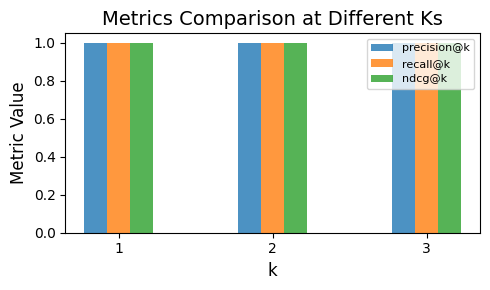

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data
metrics = ["precision", "recall", "ndcg"]
k_values = [1, 2, 3]
bar_width = 0.15
opacity = 0.8

# Create subplots
fig, ax = plt.subplots(figsize=(5, 3))

# Plotting each metric
for i, metric_name in enumerate(metrics):
    y = [evaluate_results.metrics[f"{metric_name}_at_{k}/mean"] for k in k_values]
    x = np.arange(len(k_values)) + i * bar_width
    ax.bar(x, y, width=bar_width, alpha=opacity, label=f"{metric_name}@k")

# Adding labels and title
ax.set_xlabel("k", fontsize=12)
ax.set_ylabel("Metric Value", fontsize=12)
ax.set_title("Metrics Comparison at Different Ks", fontsize=14)

# Setting x-axis ticks
ax.set_xticks(np.arange(len(k_values)) + bar_width)
ax.set_xticklabels(k_values)

# Add legend and adjust layout
ax.legend(fontsize=8)
fig.tight_layout()

# Display the plot
plt.show()

### Corner case handling

There are a few corner cases handle specially for each built-in metric.

#### Empty retrieved document IDs

When no relevant docs are retrieved:

- `mlflow.metrics.precision_at_k(k)` is defined as:
  * 0 if the ground-truth doc IDs is non-empty
  * 1 if the ground-truth doc IDs is also empty

- `mlflow.metrics.ndcg_at_k(k)` is defined as:
  * 0 if the ground-truth doc IDs is non-empty
  * 1 if the ground-truth doc IDs is also empty

#### Empty ground-truth document IDs

When no ground-truth document IDs are provided:

- `mlflow.metrics.recall_at_k(k)` is defined as:
  * 0 if the retrieved doc IDs is non-empty
  * 1 if the retrieved doc IDs is also empty

- `mlflow.metrics.ndcg_at_k(k)` is defined as:
  * 0 if the retrieved doc IDs is non-empty
  * 1 if the retrieved doc IDs is also empty

#### Duplicate retreived document IDs

It is a common case for the retriever in a RAG system to retrieve multiple chunks in the same document for a given query. In this case, `mlflow.metrics.ndcg_at_k(k)` is calculated as follows:

If the duplicate doc IDs are in the ground truth,
       they will be treated as different docs. For example, if the ground truth doc IDs are
       [1, 2] and the retrieved doc IDs are [1, 1, 1, 3], the score will be equavalent to
       ground truth doc IDs [10, 11, 12, 2] and retrieved doc IDs [10, 11, 12, 3].

If the duplicate doc IDs are not in the ground truth, the ndcg score is calculated as normal.

## Step 4: Result Analysis and Visualization

You can view the per-row scores in the logged "eval_results_table.json" in artifacts by either loading it to a pandas dataframe (shown below) or visiting the MLflow run comparison UI.

In [22]:
eval_results_table = evaluate_results.tables["eval_results_table"]
eval_results_table.head(5)

question  \
0  What are her research responsibilities in corn...   
1  What important degree day benchmark did some p...   

                                              source  \
0  [Moths Abundant Around Iowa _ Integrated Crop ...   
1  [Start Scouting for Stalk Borer _ Integrated C...   

                                   retrieved_doc_ids  precision_at_1/score  \
0  [agllm-data/Moths Abundant Around Iowa _ Integ...                     0   
1  [agllm-data/Start Scouting for Stalk Borer _ I...                     0   

   precision_at_2/score  precision_at_3/score  recall_at_1/score  \
0                     0                     0                  0   
1                     0                     0                  0   

   recall_at_2/score  recall_at_3/score  ndcg_at_1/score  ndcg_at_2/score  \
0                  0                  0                0         0.000000   
1                  0                  0                0         0.386853   

   ndcg_at_3/score  
0         0.306574  
1         0.530721

With the evaluate results table, you can further visualize the well-answered questions and poorly-answered questions using topical analysis techniques.

In [ ]:
import nltk
import pyLDAvis.gensim_models as gensimvis
from gensim import corpora, models
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Initialize NLTK resources
nltk.download("punkt")
nltk.download("stopwords")


def topical_analysis(questions: List[str]):
    stop_words = set(stopwords.words("english"))

    # Tokenize and remove stop words
    tokenized_data = []
    for question in questions:
        tokens = word_tokenize(question.lower())
        filtered_tokens = [word for word in tokens if word not in stop_words and word.isalpha()]
        tokenized_data.append(filtered_tokens)

    # Create a dictionary and corpus
    dictionary = corpora.Dictionary(tokenized_data)
    corpus = [dictionary.doc2bow(text) for text in tokenized_data]

    # Apply LDA model
    lda_model = models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

    # Get topic distribution for each question
    topic_distribution = []
    for i, ques in enumerate(questions):
        bow = dictionary.doc2bow(tokenized_data[i])
        topics = lda_model.get_document_topics(bow)
        topic_distribution.append(topics)
        print(f"Question: {ques}\nTopic: {topics}")

    # Print all topics
    print("\nTopics found are:")
    for idx, topic in lda_model.print_topics(-1):
        print(f"Topic: {idx} \nWords: {topic}\n")
    return lda_model, corpus, dictionary

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/liang.zhang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/liang.zhang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
filtered_df = eval_results_table[eval_results_table["precision_at_1/score"] == 1]
hit_questions = filtered_df["question"].tolist()
filtered_df = eval_results_table[eval_results_table["precision_at_1/score"] == 0]
miss_questions = filtered_df["question"].tolist()

In [ ]:
lda_model, corpus, dictionary = topical_analysis(hit_questions)
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)

Question: What is the purpose of the MLflow Model Registry?
Topic: [(0, 0.0400703), (1, 0.040002838), (2, 0.040673085), (3, 0.04075462), (4, 0.8384991)]
Question: What is the purpose of registering a model with the Model Registry?
Topic: [(0, 0.0334267), (1, 0.033337697), (2, 0.033401005), (3, 0.033786207), (4, 0.8660484)]
Question: What can you do with registered models and model versions?
Topic: [(0, 0.04019648), (1, 0.04000775), (2, 0.040166058), (3, 0.8391777), (4, 0.040452003)]
Question: How can you add, modify, update, or delete a model in the Model Registry?
Topic: [(0, 0.025052568), (1, 0.025006149), (2, 0.025024023), (3, 0.025236268), (4, 0.899681)]
Question: How can you deploy and organize models in the Model Registry?
Topic: [(0, 0.033460867), (1, 0.033337582), (2, 0.033362914), (3, 0.8659808), (4, 0.033857808)]
Question: What method do you use to create a new registered model?
Topic: [(0, 0.028867528), (1, 0.028582651), (2, 0.882546), (3, 0.030021703), (4, 0.029982116)]
Que

In [3]:
# Uncomment the following line to render the interactive widget
# pyLDAvis.display(vis_data)

In [ ]:
lda_model, corpus, dictionary = topical_analysis(miss_questions)
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)

Question: What is the purpose of the mlflow.sklearn.log_model() method?
Topic: [(0, 0.0669118), (1, 0.06701085), (2, 0.06667974), (3, 0.73235476), (4, 0.06704286)]
Question: How can you fetch a specific model version?
Topic: [(0, 0.83980393), (1, 0.040003464), (2, 0.04000601), (3, 0.040101767), (4, 0.040084846)]
Question: How can you fetch the latest model version in a specific stage?
Topic: [(0, 0.88561153), (1, 0.028575428), (2, 0.028578365), (3, 0.0286214), (4, 0.028613236)]
Question: What can you do to promote MLflow Models across environments?
Topic: [(0, 0.8661927), (1, 0.0333396), (2, 0.03362743), (3, 0.033428304), (4, 0.033411972)]
Question: What is the name of the model and its version details?
Topic: [(0, 0.83978903), (1, 0.04000637), (2, 0.04001106), (3, 0.040105395), (4, 0.040088095)]
Question: What is the purpose of saving the model in pickled format?
Topic: [(0, 0.033948876), (1, 0.03339717), (2, 0.033340737), (3, 0.86575514), (4, 0.033558063)]
Question: What is an MLflow

In [4]:
# Uncomment the following line to render the interactive widget
# pyLDAvis.display(vis_data)